In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Loading the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# Create train/test groups using DataLoader

In [55]:
# Step 1: normalize the data to a range of [0 1]
dataNorm = (data - np.min(data))/ (np.max(data) - np.min(data))

# Step 2: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 3: Split the data into train and test data
# Using scikit-learn
# train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Using boolean vectors
cond = labels == 8
train_data,test_data  = dataT[~cond],dataT[cond]
train_labels,test_labels = labelsT[~cond],labelsT[cond]

# Step 4: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 5: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create Model

In [56]:
class ANNmodel(nn.Module):
    """
    sizes: list of layer sizes, e.g. [in, h1, h2, ..., out]
    activation: activation for hidden layers (callable)
    out_activation: activation for the final layer (callable or None)
    dropout: float in [0,1) (applied to hidden layers)
    batchnorm: bool (BatchNorm1d on hidden layers)
    """
    def __init__(self, sizes: list, activation=F.relu, out_activation=None,
                 dropout=0.0, batchnorm=False):
        super().__init__()
        assert len(sizes) >= 2, "sizes must include [in_features, out_features]"

        layers = []
        for i in range(len(sizes)-1):
            in_f, out_f = sizes[i], sizes[i+1]
            layers.append(nn.Linear(in_f, out_f))

        self.layers = nn.ModuleList(layers)
        self.activation = activation
        self.out_activation = out_activation
        self.dropout = nn.Dropout(dropout) if dropout and dropout > 0 else None
        self.bn = nn.ModuleList(
            [nn.BatchNorm1d(sizes[i+1]) for i in range(len(sizes)-2)]
        ) if batchnorm else None

    def forward(self, x):
        # hidden layers
        for i, lin in enumerate(self.layers[:-1]):
            x = lin(x)
            if self.bn: x = self.bn[i](x)
            x = self.activation(x)
            if self.dropout: x = self.dropout(x)
        # output layer
        x = self.layers[-1](x)
        if self.out_activation is not None:
            x = self.out_activation(x)
        return x


In [57]:
## function to create the model
def createANNmodel(sizes,activation,out_activation,dropout,batchnorm, optimizerAlgo,learningrate, lossfun):

  model = ANNmodel(sizes,activation=activation,out_activation=out_activation,dropout=dropout,batchnorm=batchnorm)

  # loss function
  lossfun = lossfun

  # optimizer
  optifun = getattr(torch.optim,optimizerAlgo)
  optimizer = optifun(model.parameters(),lr=learningrate)

  return model, lossfun, optimizer

In [58]:
model,lossfun,optimizer = createANNmodel(
    sizes=[784,68,68,10],
    activation=F.relu,
    out_activation=lambda x: torch.log_softmax(x, dim=1),  # specify dim
    dropout=0.0,
    batchnorm=False,
    optimizerAlgo='SGD',
    learningrate=0.01,
    lossfun=nn.NLLLoss()
)

X,y = next(iter(train_loader))
yHat = model(X)

print(' ')
print('Prediction shape:')
print(yHat.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Prediction shape:
torch.Size([32, 10])
 
Loss:
tensor(2.3211, grad_fn=<NllLossBackward0>)


In [59]:
## Function to train the model

def trainANNmodel(optimizerAlgo, learningrate, nEpochs=50):

  # create the model
  model,lossfun,optimizer = createANNmodel(
    sizes=[784,68,68,10],
    activation=F.relu,
    out_activation=lambda x: torch.log_softmax(x, dim=1),  # specify dim
    dropout=0.0,
    batchnorm=False,
    optimizerAlgo='SGD',
    learningrate=0.01,
    lossfun=nn.NLLLoss()
)

  # initialize losses and accuracies
  losses    = torch.zeros(nEpochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(nEpochs):

    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []

    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop (training completed for all mini-batches)

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    model.eval()

    # test accuracy
    with torch.no_grad():
      X,y = next(iter(test_loader)) # extract X,y from test dataloader
      yHat = model(X)

      # compare the following really long line of code to the training accuracy lines
      testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

    losses[epochi] = np.mean(batchLoss)

  # end epochs

  # function output
  return trainAcc,testAcc,losses,model

In [60]:
## Train the model

trainAcc,testAcc,losses,model = trainANNmodel('SGD',0.01,nEpochs=50)
np.mean(trainAcc), np.mean(testAcc)

(np.float32(94.17975), np.float32(0.0))

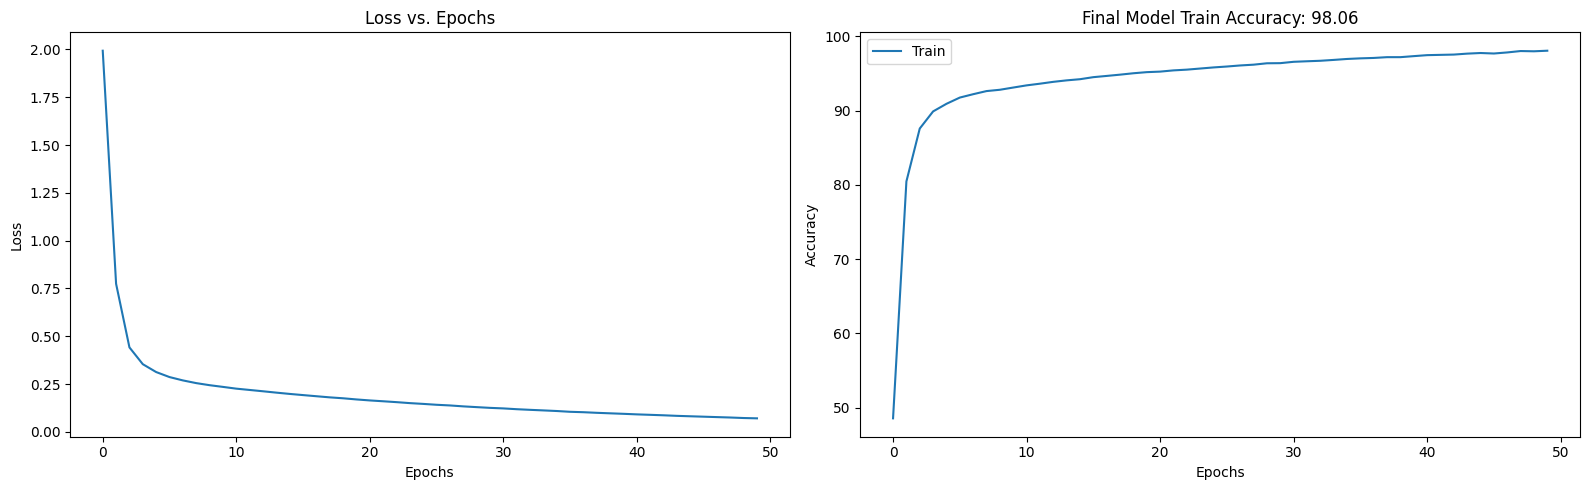

In [62]:
## Plot the performance
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,2,figsize=(16,5))

# Plot for losses. by Epochs
ax[0].plot(losses.detach().numpy())
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss vs. Epochs')

# Plot for accuracy. by Epochs
ax[1].plot(trainAcc,label='Train')
# ax[1].plot(testAcc,label='Test') # No point in calculating test accuracy hence commented. Test data is totally unknown to the model
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_title(f'Final Model Train Accuracy: {trainAcc[-1]:.2f}')


plt.tight_layout()
plt.show();

# Test the model

In [63]:
# Run the model through test data
X = next(iter(test_loader))[0]
yHat = model(X).detach()

# Save the model predictions
pred = torch.argmax(yHat,axis=1)

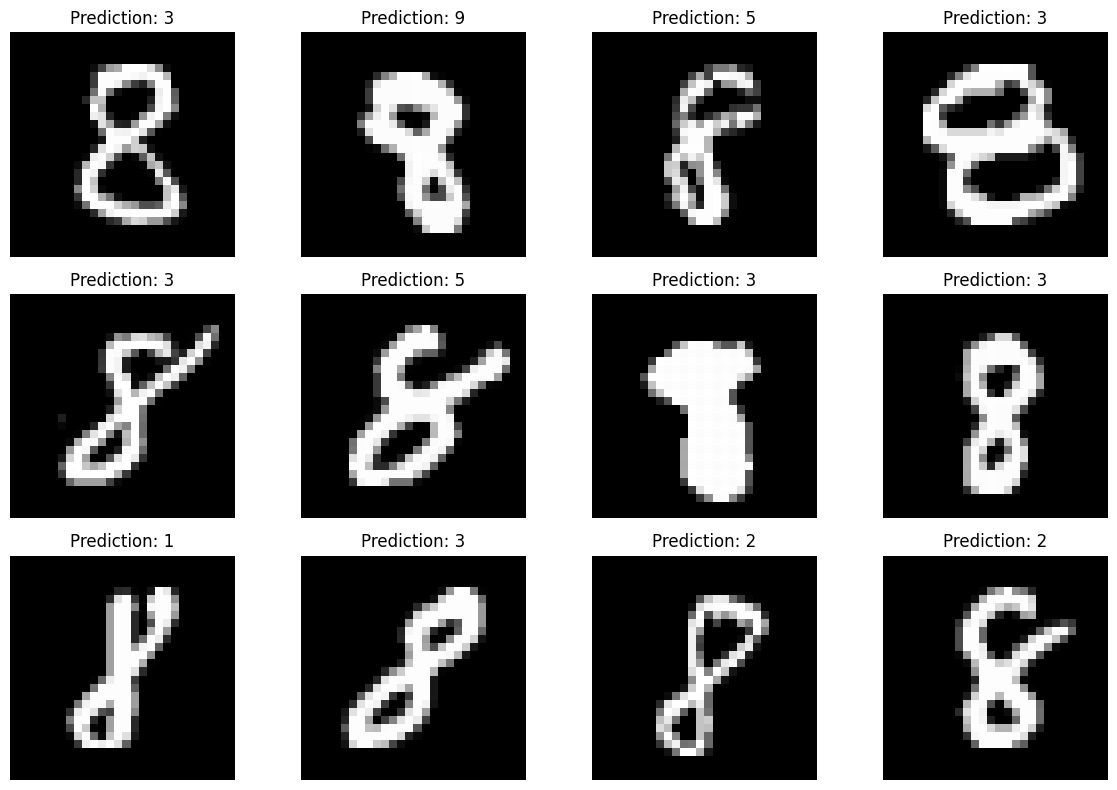

In [64]:
# Visualize the predictions
fig, axs = plt.subplots(3,4, figsize=(12,8))

rand_nos = np.random.choice(len(X),12)

for i, ax in enumerate(axs.flatten()):
  img = X[rand_nos[i]].reshape(28,28)
  ax.imshow(img,cmap='gray')
  ax.set_title(f'Prediction: {pred[rand_nos[i]]}')
  ax.axis('off')

plt.tight_layout()
plt.show();

(array([0, 1, 2, 3, 4, 5, 6, 7, 9]), array([ 52, 212, 228, 801,  33, 324,  52,  15, 195]))


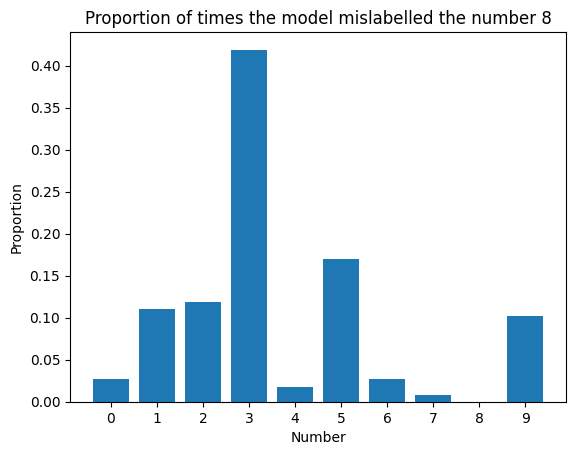

In [65]:
# Proportion of times the model mislabelled
print(np.unique(pred,return_counts=True))

probMistaken = np.zeros(10)

for i in range(10):
  probMistaken[i] = torch.mean((pred==i).float())

plt.bar(range(10),probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion')
plt.title(f'Proportion of times the model mislabelled the number {np.unique(test_labels)[0]}')

plt.show();


In [54]:
np.unique(test_labels).flatten()

array([7])